# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings

# Ignore Seaborn warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Udacity AZDIAS Subset has {azdias.shape[0]} rows and {azdias.shape[1]} columns  \n')
print(azdias.head(3))

Udacity AZDIAS Subset has 891221 rows and 85 columns  

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4                 5  ...         2.0         3.0   
2                      3                 5  ...         3.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN  

In [4]:
print(f'AZDIAS Feature Summary has {feat_info.shape[0]} rows and {feat_info.shape[1]} columns')
print(feat_info.head(3))

AZDIAS Feature Summary has 85 rows and 4 columns
              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
print(f'{azdias.isna().sum().sum()} values are naturally missing')

4896838 values are naturally missing


In [10]:
feat_info.missing_or_unknown.value_counts()

missing_or_unknown
[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[-1,X]       1
[XX]         1
[-1,XX]      1
Name: count, dtype: int64

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

# creating a copy of the data to work with
azdias_copy = azdias.copy()

# get missing_or_unknown dict
def get_missing_or_unknown_dict(feat_info):
    missing_unknown_dict = {}
    for attr, miss in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if len(miss) == 2:
            missing_unknown_dict[attr] = ''
        else:
            miss = miss[1:-1].split(',')
            miss_tmp = []
            for m in miss:
                tmp = 0
                try:
                    tmp = int(m)
                except:
                    tmp = m
                miss_tmp.append(tmp)
            missing_unknown_dict[attr] = miss_tmp
    return missing_unknown_dict
            
# Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value
def set_missing_unknown_to_nan(azdias_copy, missing_unknown_dict):
    for key in missing_unknown_dict:
        if missing_unknown_dict[key] == '':
            continue
        else:
            for val in missing_unknown_dict[key]:
                azdias_copy[key].replace(val, np.NaN, inplace = True)
    return azdias_copy

missing_unknown_dict = get_missing_or_unknown_dict(feat_info)
azdias_copy = set_missing_unknown_to_nan(azdias_copy, missing_unknown_dict)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
pd.set_option('display.max_rows', None)
print(azdias_copy.isna().sum().sort_values(ascending=False))
pd.reset_option('display.max_rows')

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_ANTG1               116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
VERS_TYP                 111196
HEALTH_TYP               111196
SHOPPER_TYP              111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

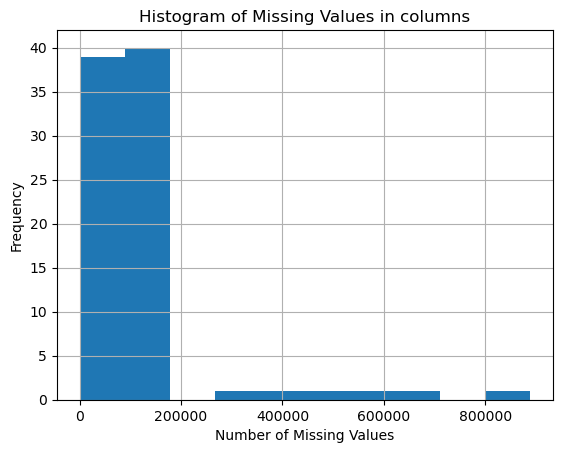

In [13]:
# Investigate patterns in the amount of missing data in each column.
azdias_missing_column = azdias_copy.isna().sum()
azdias_missing_column.hist()

plt.xlabel('Number of Missing Values')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Values in columns')
plt.show()

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = []
cols = azdias_copy.columns
for col in cols:
    if azdias_missing_column[col] > 200000:
        outlier_columns.append(col)
print('outlier columns:', outlier_columns)
azdias_copy.drop(outlier_columns, axis=1, inplace=True)

outlier columns: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [15]:
azdias_copy.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column
Most columns have 15000 values or less. There is a big jump of 15000 values from the 'KKK' column to the 'ALTER_HH' column. Therefore I removed the columns with 20000 values or more. Those columns were 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

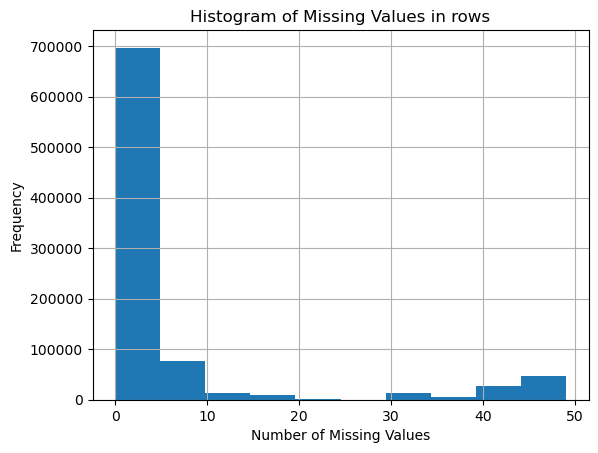

In [16]:
# How much data is missing in each row of the dataset?
azdias_missing_row = azdias_copy.isna().sum(axis=1)
azdias_missing_row.hist()

plt.xlabel('Number of Missing Values')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Values in rows')
plt.show()

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 5
# Create two subsets based on the threshold
subset_with_few_missing = azdias_copy[azdias_missing_row <= threshold]
subset_with_many_missing = azdias_copy[azdias_missing_row > threshold]

print("Subset with Few Missing Values Shape:", subset_with_few_missing.shape[0])
print("Subset with Many Missing Values Shape:", subset_with_many_missing.shape[0])

Subset with Few Missing Values Shape: 719624
Subset with Many Missing Values Shape: 171597


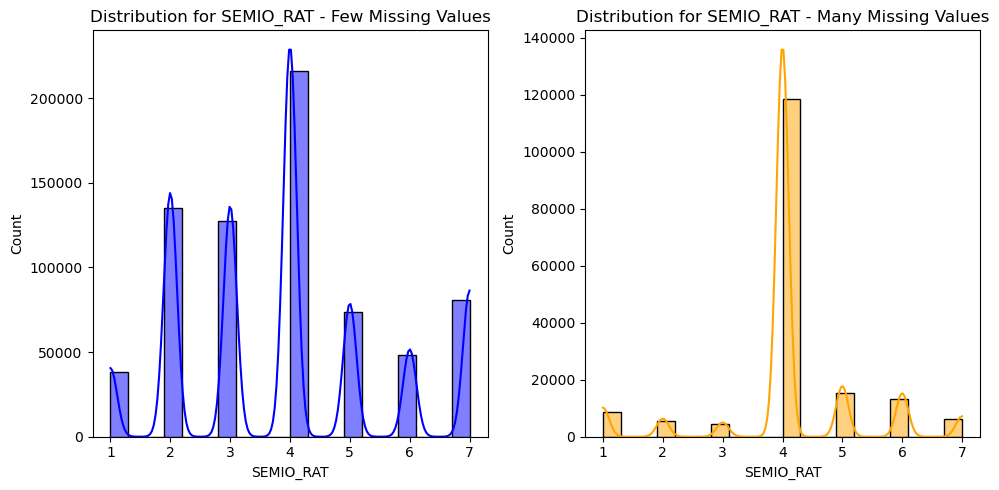

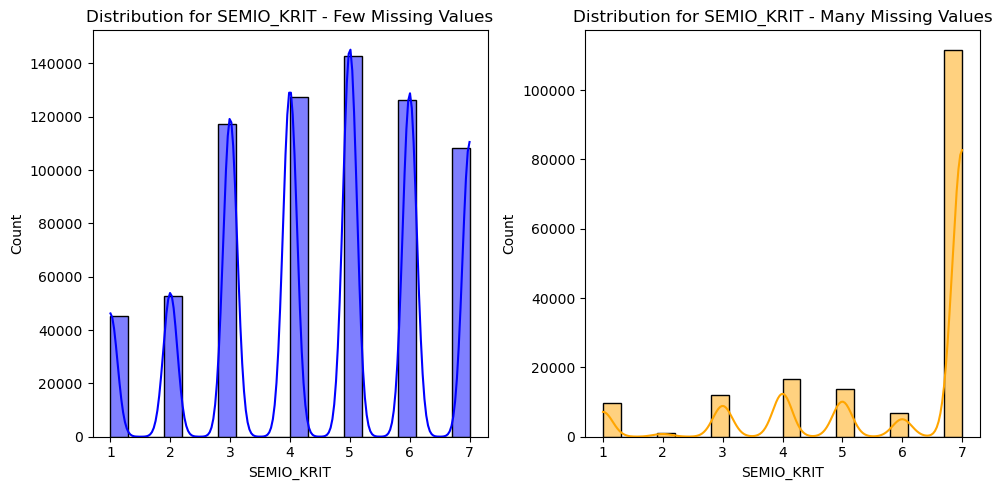

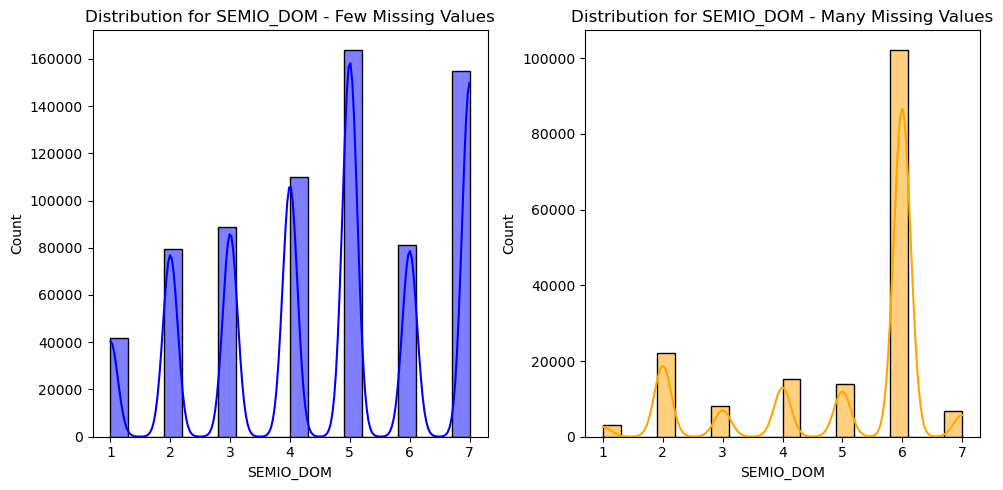

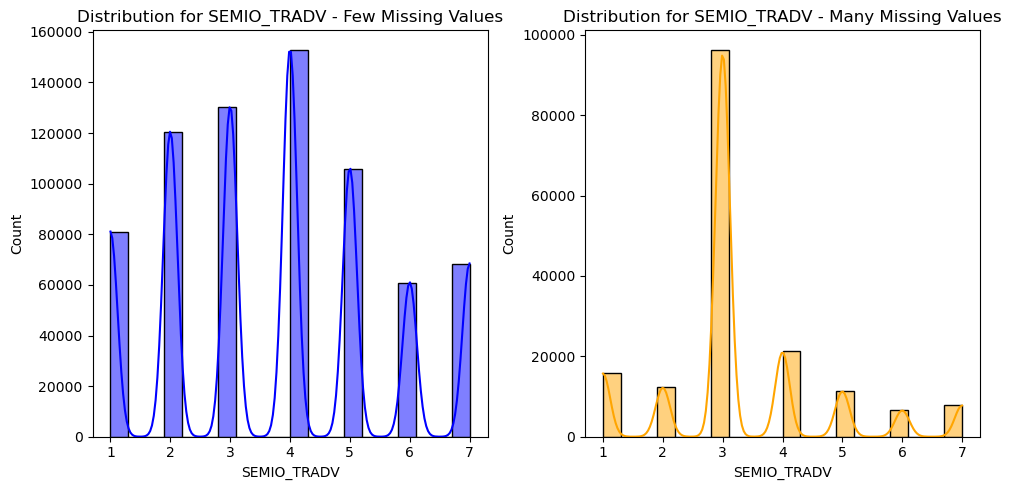

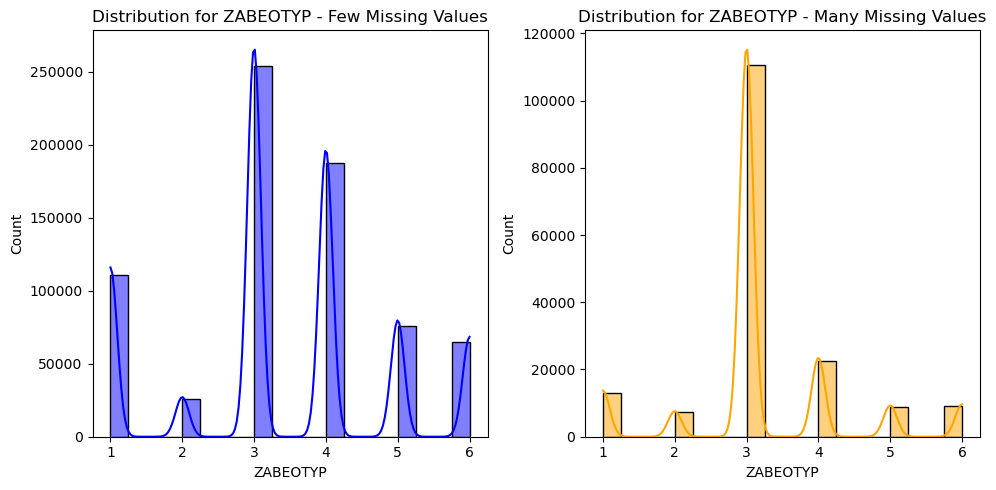

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Choose at least five columns with no or few missing values
columns_to_compare = ['SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_TRADV', 'ZABEOTYP']

# Plot the distributions for each column in both subsets
for column in columns_to_compare:
    plt.figure(figsize=(10, 5))
    
    # Distribution for subset_with_few_missing
    plt.subplot(1, 2, 1)
    sns.histplot(subset_with_few_missing[column], bins=20, kde=True, color='blue')
    plt.title(f'Distribution for {column} - Few Missing Values')

    # Distribution for subset_with_many_missing
    plt.subplot(1, 2, 2)
    sns.histplot(subset_with_many_missing[column], bins=20, kde=True, color='orange')
    plt.title(f'Distribution for {column} - Many Missing Values')

    plt.tight_layout()
    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The first subset has less than 5 missing values. The second subset has more than 5 missing values. The first subset has a more even distribution. The second subset has one value that is much higher than the others.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# dropping the outliers in feat_info that I dropped in the dataframe
feat_info_cleaned = feat_info.copy()
for row in ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']:
    feat_info_cleaned.drop(feat_info_cleaned[feat_info_cleaned['attribute']==row].index[0], axis = 0, inplace=True)

In [20]:
# How many features are there of each data type?
feat_info_cleaned.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
print("Number of features:", subset_with_few_missing.shape[1])

Number of features: 79


In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features_list = feat_info_cleaned[feat_info_cleaned['type'] == 'categorical']['attribute'].tolist()

In [23]:
# get non_binary columns and multi_level columns
binary_dict = {}
multi_level_dict = {}
for feature in categorical_features_list:
    categories = list(set(list(subset_with_few_missing[subset_with_few_missing[feature].notnull()][feature])))
    if len(categories) == 2:
        binary_dict[feature] = categories
    else:
        multi_level_dict[feature] = categories

print('binary features:', binary_dict)
print('\nmulti level features:', multi_level_dict)

binary features: {'ANREDE_KZ': [1, 2], 'GREEN_AVANTGARDE': [0, 1], 'SOHO_KZ': [0.0, 1.0], 'VERS_TYP': [1.0, 2.0], 'OST_WEST_KZ': ['W', 'O']}

multi level features: {'CJT_GESAMTTYP': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 'FINANZTYP': [1, 2, 3, 4, 5, 6], 'GFK_URLAUBERTYP': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0], 'LP_FAMILIE_FEIN': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0], 'LP_FAMILIE_GROB': [1.0, 2.0, 3.0, 4.0, 5.0], 'LP_STATUS_FEIN': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], 'LP_STATUS_GROB': [1.0, 2.0, 3.0, 4.0, 5.0], 'NATIONALITAET_KZ': [1.0, 2.0, 3.0], 'SHOPPER_TYP': [0.0, 1.0, 2.0, 3.0], 'ZABEOTYP': [1, 2, 3, 4, 5, 6], 'GEBAEUDETYP': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0], 'CAMEO_DEUG_2015': ['1', '6', '2', '5', '3', '7', '4', '8', '9'], 'CAMEO_DEU_2015': ['7B', '7E', '6D', '5F', '6F', '5B', '1D', '6E', '2C', '1B', '9E', '8C', '2D', '5C', '6C', '5E', '7A', '3C', '1C', '9C', '3D', '4D', '5A', '8B', '3B', '1A', '4B', '1E', '9B', '2B', '4C', 

In [24]:
print(subset_with_few_missing['OST_WEST_KZ'].unique())

['W' 'O']


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.
subset_wfm_copy = subset_with_few_missing.copy()
subset_wfm_copy['OST_WEST_KZ'] = subset_wfm_copy['OST_WEST_KZ'].replace(['W', 'O'], [0, 1])
print(subset_wfm_copy['OST_WEST_KZ'].unique())

[0 1]


In [26]:
# remove multilevel categorical variables
# Convert keys of multi_level_dict to a list
multilevel_columns = list(multi_level_dict.keys())
subset_wfm_copy = subset_wfm_copy.drop(columns=multilevel_columns)

# Update feat_info_cleaned by removing rows corresponding to multilevel variables
feat_info_cleaned = feat_info_cleaned[~feat_info_cleaned['attribute'].isin(multilevel_columns)]

In [27]:
print("Number of features:", subset_wfm_copy.shape[1])

Number of features: 66


#### Discussion 1.2.1: Re-Encode Categorical Features

I found 5 binary features, including 1 that was non-numerical. I also found 13 multi-level features. I re-encoded the 1 non-numerical feature into numerical. I dropped the 13 multi-level features because I wanted to keep things straightforward.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
subset_wfm_copy['PRAEGENDE_JUGENDJAHRE'].value_counts()

PRAEGENDE_JUGENDJAHRE
14.0    168815
8.0     130339
5.0      80064
10.0     78492
3.0      50728
15.0     38221
11.0     31951
9.0      31607
6.0      24650
12.0     22855
4.0      19715
1.0      18924
2.0       7044
13.0      5050
7.0       3805
Name: count, dtype: int64

In [29]:
subset_wfm_copy['PRAEGENDE_JUGENDJAHRE_movement'] = subset_wfm_copy['PRAEGENDE_JUGENDJAHRE']
subset_wfm_copy['PRAEGENDE_JUGENDJAHRE_movement'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],\
                                   [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0], inplace=True)
subset_wfm_copy['PRAEGENDE_JUGENDJAHRE_decade'] = subset_wfm_copy['PRAEGENDE_JUGENDJAHRE']
subset_wfm_copy['PRAEGENDE_JUGENDJAHRE_decade'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],\
                                 [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90], inplace=True)

In [30]:
# drop original column
subset_wfm_copy.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
subset_wfm_copy['CAMEO_INTL_2015'].value_counts()

CAMEO_INTL_2015
51    124571
41     84709
24     81970
14     56623
43     52027
54     42522
25     36138
22     29027
45     24492
13     23488
55     22016
23     19147
52     19044
34     16913
15     15743
31     15498
44     13604
12     11439
35      9558
32      9344
33      8694
Name: count, dtype: int64

In [32]:
subset_wfm_copy['CAMEO_INTL_2015_wealth'] = (pd.to_numeric(subset_wfm_copy['CAMEO_INTL_2015'])/10).round(0)

subset_wfm_copy['CAMEO_INTL_2015_lifeStage'] = (pd.to_numeric(subset_wfm_copy['CAMEO_INTL_2015'])%10).round(0)

In [33]:
# drop original column
subset_wfm_copy.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)

In [34]:
subset_wfm_copy.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 

#### Discussion 1.2.2: Engineer Mixed-Type Features

I dropped 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' and replaced them with 4 new columns that seperated the mixed-value features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# renaming df and dropping NaN's
azdias_cleaned = subset_wfm_copy
azdias_cleaned = azdias_cleaned.dropna()

In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_unknown_dict = get_missing_or_unknown_dict(feat_info_cleaned)
    df = set_missing_unknown_to_nan(df, missing_unknown_dict)
   
    # remove selected columns and rows, ...
    # drop outlier columns
    outliers = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH', 'KK_KUNDENTYP','KBA05_BAUMAX']
    
    df.drop(columns = outliers, inplace = True)
    
    # Create subset that will remove rows based on the threshold
    threshold = 5
    df_missing_row = df.isna().sum(axis=1)
    subset_wfm = df[df_missing_row <= threshold]
    
    # select, re-encode, and engineer column values.
    # re-encode non numerical binary feature
    subset_wfm.loc[:, 'OST_WEST_KZ'] = subset_wfm['OST_WEST_KZ'].replace(['W', 'O'], [0, 1])

    # drop multi-level features
    subset_wfm = subset_wfm.drop(columns=multilevel_columns)

    # engineer new columns
    # create 2 new columns and drop old column
    subset_wfm['PRAEGENDE_JUGENDJAHRE_movement'] = subset_wfm['PRAEGENDE_JUGENDJAHRE']
    subset_wfm['PRAEGENDE_JUGENDJAHRE_movement'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],\
                                       [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0], inplace=True)
    subset_wfm['PRAEGENDE_JUGENDJAHRE_decade'] = subset_wfm['PRAEGENDE_JUGENDJAHRE']
    subset_wfm['PRAEGENDE_JUGENDJAHRE_decade'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],\
                                     [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90], inplace=True)
    subset_wfm.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

    # create 2 new columns and drop old column
    subset_wfm['CAMEO_INTL_2015_wealth'] = (pd.to_numeric(subset_wfm['CAMEO_INTL_2015'])/10).round(0)
    subset_wfm['CAMEO_INTL_2015_lifeStage'] = (pd.to_numeric(subset_wfm['CAMEO_INTL_2015'])%10).round(0)
    subset_wfm.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)

    # dropping NaN's
    subset_wfm = subset_wfm.dropna()
    
    # Return the cleaned dataframe.
    return subset_wfm
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [39]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

# Fit and transform the DataFrame
azdias_cleaned = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns=azdias_cleaned.columns)

print(azdias_cleaned.head(2))

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -1.746291   0.977825          -1.512224       1.581058   
1              0.202107   0.977825          -1.512224       0.900443   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -1.045042        1.539058               1.047073          1.340482   
1         -1.765051       -0.531628               0.318373          1.340482   

   GREEN_AVANTGARDE  HEALTH_TYP  ...  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0         -0.553670    1.044647  ...    -0.667337  1.441599  0.583438   
1          1.806129    1.044647  ...    -0.667337  0.400949  0.583438   

     ARBEIT  ORTSGR_KLS9  RELAT_AB  PRAEGENDE_JUGENDJAHRE_movement  \
0 -0.201181    -0.171845  0.656462                        0.553670   
1 -0.201181    -0.171845 -0.823844                       -1.806129   

   PRAEGENDE_JUGENDJAHRE_decade  CAMEO_INTL_2015_wealth  \
0                      1.164454                1.090

### Discussion 2.1: Apply Feature Scaling

I used Standard Scaler which scales features by removing the mean and scaling to unit variance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
pca = PCA(random_state=42)
pca.fit_transform(azdias_cleaned)

array([[ 3.34260540e+00, -2.93016278e+00, -3.02891999e+00, ...,
         1.27982906e-01, -1.65174867e-01,  7.21652322e-15],
       [-7.71290698e-01,  2.66403468e-01, -3.07110429e+00, ...,
        -4.83365311e-02,  5.57167513e-02, -1.94750380e-14],
       [ 8.71852166e-02,  6.89102754e-02,  3.22840043e+00, ...,
         3.53583535e-01,  3.59156911e-02, -9.98769549e-14],
       ...,
       [ 3.56229101e+00, -2.07069606e+00, -3.68844370e+00, ...,
        -1.63778002e-01,  6.14723877e-02, -7.41378291e-18],
       [ 5.60875796e+00, -3.50819224e+00,  2.18916674e+00, ...,
        -1.66390621e-01, -2.94541131e-02, -6.05663166e-17],
       [-5.90695556e-01,  1.02446545e+00,  2.83792694e+00, ...,
         2.45282974e-01,  6.21130733e-02, -9.82510957e-17]])

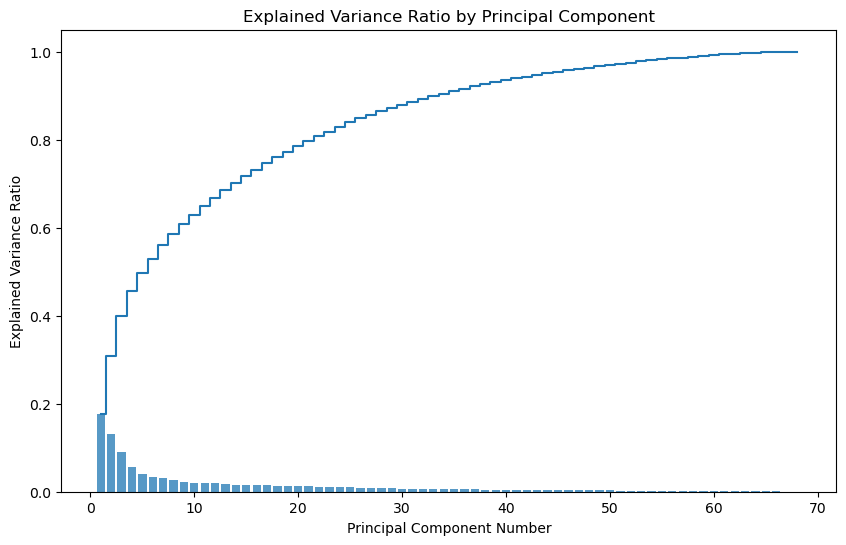

In [41]:
# Investigate the variance accounted for by each principal component.

# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio for each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.75, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component Number')
plt.ylabel("Explained Variance Ratio")
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

In [42]:
# Figuring out the number of components needed to retain 95% of total variance
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components to retain: {num_components}")

Number of components to retain: 44


In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_reduced = PCA(n_components=44, random_state=42)
pca_reduced.fit_transform(azdias_cleaned)
pca_population = pca_reduced.transform(azdias_cleaned)
print("Cumulative explained variance ratio: ", np.sum(pca_reduced.explained_variance_ratio_))

Cumulative explained variance ratio:  0.9507303051467417


### Discussion 2.2: Perform Dimensionality Reduction

I found that reducing the components to 44 gave a 95% total variance threshold. I used the 95% threshold since its a common threshold and retains a large amount of variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [44]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_top_features(pca_model, component_index, feature_names, n_top_features=10):
    """
    Print the top features and their weights for a given principal component.

    Parameters:
    - pca_model: Trained PCA model
    - component_index: Index of the principal component to analyze
    - feature_names: List of feature names in the same order as they appear in the dataset
    - n_top_features: Number of top features to display (default is 10)
    """
    # Get the weights for the specified principal component
    weights = pca_model.components_[component_index - 1]

    # Create a DataFrame to store feature names and their corresponding weights
    feature_weights = pd.DataFrame({'Feature': feature_names, 'Weight': weights})

    # Sort the DataFrame by the absolute value of weights in descending order
    feature_weights = feature_weights.reindex(feature_weights['Weight'].sort_values(ascending=False).index)

    # Display the top features
    print(f"Top {n_top_features} features for Principal Component {component_index}:")
    print(feature_weights.head(n_top_features))
    print("\n")

In [45]:
print_top_features(pca_reduced, 1, azdias_cleaned.columns, n_top_features=68)

Top 68 features for Principal Component 1:
                   Feature    Weight
56              PLZ8_ANTG3  0.216637
57              PLZ8_ANTG4  0.211282
58             PLZ8_BAUMAX  0.208115
66  CAMEO_INTL_2015_wealth  0.191731
31      HH_EINKOMMEN_SCORE  0.191168
..                     ...       ...
2        FINANZ_MINIMALIST -0.205479
44               KBA05_GBZ -0.207907
40             KBA05_ANTG1 -0.217177
54              PLZ8_ANTG1 -0.218139
50              MOBI_REGIO -0.232593

[68 rows x 2 columns]




In [46]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_top_features(pca_reduced, 2, azdias_cleaned.columns, n_top_features=68)

Top 68 features for Principal Component 2:
                         Feature    Weight
0           ALTERSKATEGORIE_GROB  0.263065
19                     SEMIO_ERL  0.233461
4               FINANZ_VORSORGER  0.230425
18                    SEMIO_LUST  0.182319
12                RETOURTYP_BK_S  0.164941
..                           ...       ...
26                   SEMIO_TRADV -0.232546
3                  FINANZ_SPARER -0.238888
25                 SEMIO_PFLICHT -0.241540
65  PRAEGENDE_JUGENDJAHRE_decade -0.252051
15                     SEMIO_REL -0.265506

[68 rows x 2 columns]




In [47]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_top_features(pca_reduced, 3, azdias_cleaned.columns, n_top_features=68)

Top 68 features for Principal Component 3:
              Feature    Weight
17         SEMIO_VERT  0.349189
13          SEMIO_SOZ  0.263951
14          SEMIO_FAM  0.251822
20         SEMIO_KULT  0.232738
2   FINANZ_MINIMALIST  0.161479
..                ...       ...
21          SEMIO_RAT -0.217262
22         SEMIO_KRIT -0.270855
23          SEMIO_DOM -0.311969
24         SEMIO_KAEM -0.338158
1           ANREDE_KZ -0.368034

[68 rows x 2 columns]




### Discussion 2.3: Interpret Principal Components

Principal Component 1: Positive values are associated with higher numbers of larger family houses, higher income, and greater wealth, while negative values are associated with lower financial interest, smaller family houses, and lower income.

Principal Component 2: Positive values are associated with older age, being event-oriented, financially prepared, and sensual-minded, while negative values are associated with traditional-mindedness, money-saving behavior, and religious orientation.

Principal Component 3: Positive values are associated with dreamful, socially-minded, family-minded, and culturally-minded personalities, while negative values are associated with rational, critical-minded, dominant-minded, and combative attitudes, along with being male.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [48]:
# Function to compute average within-cluster distances
def compute_avg_distance(data, kmeans_model):
    return -kmeans_model.score(data) / data.shape[0]

In [49]:
# Over a number of different cluster counts...
# Test for different cluster counts
cluster_counts = list(range(2, 11))

# run k-means clustering on the data and...
avg_distances = []
for k in cluster_counts:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_population)
    
    # compute the average within-cluster distances.
    avg_distance = compute_avg_distance(pca_population, kmeans)
    avg_distances.append(avg_distance)
    
    print(f"Number of clusters: {k}, Average distance: {avg_distance}")
    

Number of clusters: 2, Average distance: 55.61471082721914
Number of clusters: 3, Average distance: 51.210100663364635
Number of clusters: 4, Average distance: 48.46985515344333
Number of clusters: 5, Average distance: 46.59025693026285
Number of clusters: 6, Average distance: 44.91541613866537
Number of clusters: 7, Average distance: 43.46495075275443
Number of clusters: 8, Average distance: 42.30158930389397
Number of clusters: 9, Average distance: 41.44486750488731
Number of clusters: 10, Average distance: 40.642313093644375


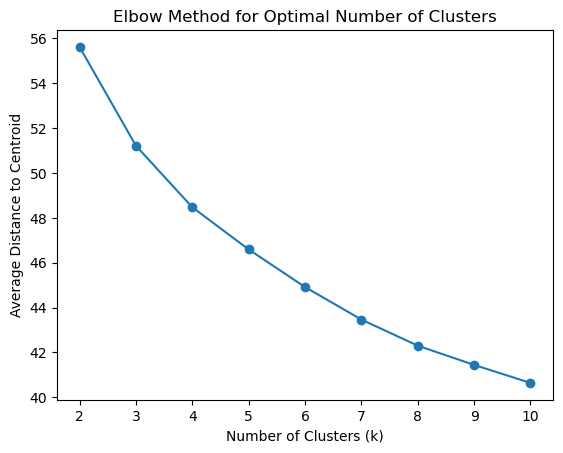

In [50]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_counts, avg_distances, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Distance to Centroid')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [51]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Choose the optimal number of clusters based on the plot
optimal_clusters = 5

# Refit KMeans with the optimal number of clusters
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42, n_init = 10)
kmeans_final.fit(pca_population)

# Obtain cluster assignments for the general demographics data
cluster_assignments = kmeans_final.predict(pca_population)

### Discussion 3.1: Apply Clustering to General Population

I decided to use 5 clusters. The elbow method showed that the average distance slowed down from greater increments to increments of 1 after 5 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [52]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [53]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# preprocessing
customers = clean_data(customers)

# scale
customers_cleaned = pd.DataFrame(scaler.transform(customers), columns=customers.columns)

# pca
customers_pca = pca_reduced.transform(customers_cleaned)

# cluster
customers_clusters = kmeans_final.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

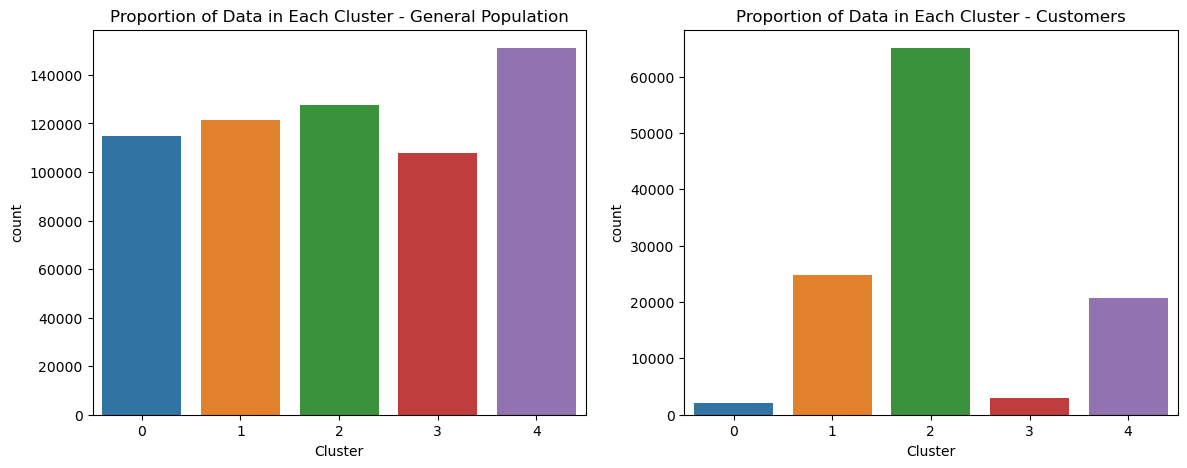

In [54]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Combine cluster assignments with the respective datasets
customers_cleaned['Cluster'] = customers_clusters
azdias_cleaned['Cluster'] = cluster_assignments

# Plot the proportion of data in each cluster for the general population
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Cluster', data=azdias_cleaned)
plt.title('Proportion of Data in Each Cluster - General Population')

# Plot the proportion of data in each cluster for the customer data
plt.subplot(1, 2, 2)
sns.countplot(x='Cluster', data=customers_cleaned)
plt.title('Proportion of Data in Each Cluster - Customers')

plt.show()

In [55]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Calculate proportions for each cluster in the general population
general_cluster_proportions = azdias_cleaned['Cluster'].value_counts(normalize=True).sort_index()

# Calculate proportions for each cluster in the customer data
customer_cluster_proportions = customers_cleaned['Cluster'].value_counts(normalize=True).sort_index()

# Identify overrepresented clusters
overrepresented_clusters = customer_cluster_proportions > general_cluster_proportions

# Print overrepresented clusters
print("Overrepresented Clusters:")
print(customer_cluster_proportions[overrepresented_clusters])

Overrepresented Clusters:
Cluster
1    0.214773
2    0.562715
Name: proportion, dtype: float64


In [56]:
# DF without Cluster to work with top_features function
customers_cleaned_without_cluster = customers_cleaned.drop('Cluster', axis=1)
# Cluster 1 - Overrepresented
print_top_features(pca_reduced, 1, customers_cleaned_without_cluster.columns, n_top_features=68)

Top 68 features for Principal Component 1:
                   Feature    Weight
56              PLZ8_ANTG3  0.216637
57              PLZ8_ANTG4  0.211282
58             PLZ8_BAUMAX  0.208115
66  CAMEO_INTL_2015_wealth  0.191731
31      HH_EINKOMMEN_SCORE  0.191168
..                     ...       ...
2        FINANZ_MINIMALIST -0.205479
44               KBA05_GBZ -0.207907
40             KBA05_ANTG1 -0.217177
54              PLZ8_ANTG1 -0.218139
50              MOBI_REGIO -0.232593

[68 rows x 2 columns]




Positive values are associated with large poorer families, while negative values are associated with low financial interest, small families and lower movement patterns.

In [57]:
# Cluster 2 - Overrepresented
print_top_features(pca_reduced, 2, customers_cleaned_without_cluster.columns, n_top_features=68)

Top 68 features for Principal Component 2:
                         Feature    Weight
0           ALTERSKATEGORIE_GROB  0.263065
19                     SEMIO_ERL  0.233461
4               FINANZ_VORSORGER  0.230425
18                    SEMIO_LUST  0.182319
12                RETOURTYP_BK_S  0.164941
..                           ...       ...
26                   SEMIO_TRADV -0.232546
3                  FINANZ_SPARER -0.238888
25                 SEMIO_PFLICHT -0.241540
65  PRAEGENDE_JUGENDJAHRE_decade -0.252051
15                     SEMIO_REL -0.265506

[68 rows x 2 columns]




Positive values are associated with older, event-oriented, financially prepared, sensual-minded and lower returners, while negative values are associated with tradional-minded, money-savers, dutiful, younger, religious.

In [58]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Identify underrepresented clusters
underrepresented_clusters = customer_cluster_proportions < general_cluster_proportions

# Print underrepresented clusters
print("\nUnderrepresented Clusters:")
print(customer_cluster_proportions[underrepresented_clusters])


Underrepresented Clusters:
Cluster
0    0.018280
3    0.025587
4    0.178645
Name: proportion, dtype: float64


In [59]:
# Cluster 0 - Underrepresented
print_top_features(pca_reduced, 0, customers_cleaned_without_cluster.columns, n_top_features=68)

Top 68 features for Principal Component 0:
        Feature    Weight
46     EWDICHTE  0.530259
47   INNENSTADT  0.285808
39     WOHNLAGE  0.259558
23    SEMIO_DOM  0.234445
17   SEMIO_VERT  0.187489
..          ...       ...
19    SEMIO_ERL -0.150655
52     REGIOTYP -0.175902
61       ARBEIT -0.188017
58  PLZ8_BAUMAX -0.231033
14    SEMIO_FAM -0.254713

[68 rows x 2 columns]




Positive values are associated with dense housing but far from the city center, worse neighborhoods, dominant-minded and dreamful while negative values are associated with event-oriented, lower class, higher unemployment, larger family homes and family-minded.

In [60]:
# Cluster 3 - Underrepresented
print_top_features(pca_reduced, 3, customers_cleaned_without_cluster.columns, n_top_features=68)

Top 68 features for Principal Component 3:
              Feature    Weight
17         SEMIO_VERT  0.349189
13          SEMIO_SOZ  0.263951
14          SEMIO_FAM  0.251822
20         SEMIO_KULT  0.232738
2   FINANZ_MINIMALIST  0.161479
..                ...       ...
21          SEMIO_RAT -0.217262
22         SEMIO_KRIT -0.270855
23          SEMIO_DOM -0.311969
24         SEMIO_KAEM -0.338158
1           ANREDE_KZ -0.368034

[68 rows x 2 columns]




Positive values are associated with dreamful, socially-minded, family-minded, cultural-minded and low financial interest, while negative values are associated with rational, critical-minded, dominant-minded, combative attitude and female.

In [61]:
# Cluster 4 - Underrepresented
print_top_features(pca_reduced, 4, customers_cleaned_without_cluster.columns, n_top_features=68)

Top 68 features for Principal Component 4:
                           Feature    Weight
8                 GREEN_AVANTGARDE  0.344675
46                        EWDICHTE  0.248509
62                     ORTSGR_KLS9  0.246881
10             LP_LEBENSPHASE_FEIN  0.210182
11             LP_LEBENSPHASE_GROB  0.206464
..                             ...       ...
49                             KKK -0.207358
45                        BALLRAUM -0.214093
31              HH_EINKOMMEN_SCORE -0.239873
39                        WOHNLAGE -0.260075
64  PRAEGENDE_JUGENDJAHRE_movement -0.344675

[68 rows x 2 columns]




Positive values are associated with members of green avantgarde, areas with low density of households, large communities and multi-person households while negative values are associated with low purchasing power, far from urban centers and lower income.

### Discussion 3.3: Compare Customer Data to Demographics Data

I found that cluster 1 and 2 are overrepresnted and 0,3 and 4 are underrepresented. Cluster 2 seemed to be the most overrepresented and Cluster 4 seemed to be the most underrepresented.

Segments of the population relatively popular with mail-order company - older, event-oriented, financially prepared, sensual-minded and people who don't return items much.

Segments of the population relatively unpopular with mail-order company - members of green avantgarde, areas with low density of households, large populated areas and multi-person households.